# Forecasting Oil Prices with TSFresh using Deep Learning Models

Final project by: Sharyl Sy & Joaquin Gonzales

In this notebook, we would like to be able to forecast the stock price returns of Dubai oil prices using the features generated by TSFresh. We attempt to compare the difference between the performance of utilizing TSFresh extracted features on the Dubai oil price time-series versus using actual macroeconomic variables and media information such as Google Trends as predictors of the Dubai oil prices.

With these experiments, our team would like to see whether macroeconomic indicators and Google trends data (which are domain expert variables) could be substituted with tsFresh extracted features or not.

We load the relevant libraries for implementing deep learning models, along with tsFresh.

In [157]:
import os
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from keras.layers import Dense, SimpleRNN, Dropout
from keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf

Instead of modelling the actual Dubai oil prices, we attempt to model the actual returns or the percentage change of the Dubai oil prices relative to two consecutive time periods. This is done given that actual prices or levels of time-series data are hard to forecast, which was evident in the prior implementation.

\begin{align*}
    Returns = \frac{Price_t - Price_{t-1}}{Price_{t-1}} * 100
\end{align*}

We now load the relevant datasets, and then find the Dubai oil price returns.

In [67]:
df_crude = pd.read_csv('data/dubai_crude_oil.csv')
df_crude['Date'] = pd.to_datetime(df_crude['Date'], dayfirst=True)
df_crude = df_crude[df_crude['Date'] >= datetime.datetime(2014, 7, 11)]
df_crude = df_crude.sort_values(by='Date').reset_index().drop('index', axis=1)
df_crude = df_crude[['Date', 'Price']].set_index('Date')
df_crude['Lag'] = df_crude['Price'].shift(1)

df_crude = df_crude.dropna()
df_crude['Return'] = ((df_crude['Price'] - df_crude['Lag']) / df_crude['Lag']) * 100
df_crude

,Price,Lag,Return
Date,,,
2014-07-14,106.19,105.79,0.378108
2014-07-15,105.89,106.19,-0.282512
2014-07-16,105.94,105.89,0.047219
2014-07-17,106.36,105.94,0.396451
2014-07-18,105.97,106.36,-0.366679
...,...,...,...
2022-05-27,107.75,107.64,0.102192
2022-05-31,108.13,107.75,0.352668
2022-06-01,110.91,108.13,2.570979


Seen below is a visualization of the oil price returns from 2015 to 2022. We can see from the plot that the stock price returns tend to deviate from white noise given that the time series exhibited huge positive and negative spikes brought about by different events that have affected the global economy.

Sudden increases and drops in oil prices have taken place from 2015 to 2017 given the sudden increase in the demand for crude oil and global supply not being able to catch up. Likewise, the COVID-19 pandemic and the Russia-Ukraine conflict.

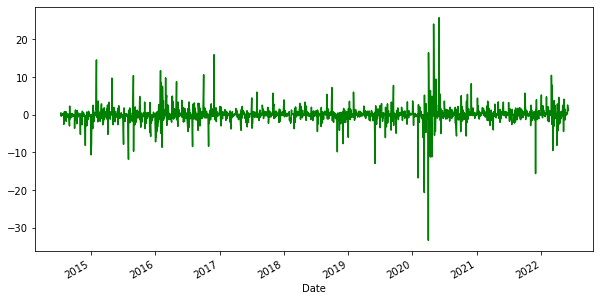

In [68]:
df_crude['Return'].plot(figsize=(10, 5), color='green')
plt.autoscale()
plt.show()

We now look at the ACF plot of the Dubai oil price returns. From the plot, we can see that there seems to be a recurring autocorrelation every 20th time-period (which represents an entire trading month). Hence, we can see that there is a monthly seasonality with the Dubai oil price returns.

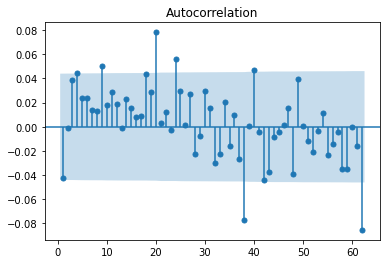

In [69]:
plot_acf(df_crude['Return'], lags=62, zero=False)
plt.autoscale()
plt.show()

## Forecasting Returns

We now attempt to forecast the returns of the Dubai crude oil prices using the covariates which we deem to be related to it, such as the CRB commodity prices, the US Dollar index, along with Google Trend searches of the term crude oil prices.

The relevant datasets are loaded and are merged with the target, taking into consideration that the Dubai crude oil prices are only available during trading days (i.e. no values during holidays and weekends).

In [70]:
df_commodity = pd.read_csv('data/crb_commodity_index.csv')
df_commodity['Date'] = pd.to_datetime(df_commodity['Date'], dayfirst=True)
df_commodity = df_commodity[df_commodity['Date'] >= datetime.datetime(2014, 7, 14)]
df_commodity = df_commodity.drop(['Open', 'High', 'Low'], axis=1)
df_commodity = df_commodity.rename(columns={'Close': 'crb_index'})
df_commodity = df_commodity.set_index('Date')
df_commodity

,crb_index
Date,
2014-07-14,297.4700
2014-07-15,296.0200
2014-07-16,296.7900
2014-07-17,297.9200
2014-07-18,297.4200
...,...
2022-05-27,320.5242
2022-05-31,316.5352
2022-06-01,320.0229


In [71]:
df_dollar = pd.read_csv('data/us_dollar_index.csv')
df_dollar = df_dollar.dropna()
df_dollar['Date'] = pd.to_datetime(df_dollar['Date'], dayfirst=True)
df_dollar = df_dollar[df_dollar['Date'] >= datetime.datetime(2014, 7, 14)]
df_dollar = df_dollar.sort_values(by='Date')
df_dollar = df_dollar[['Date', 'Price']]
df_dollar = df_dollar.rename(columns={'Price': 'us_dollar_index'})
df_dollar = df_dollar.set_index('Date')

df_dollar

,us_dollar_index
Date,
2014-07-14,80.230
2014-07-15,80.446
2014-07-16,80.625
2014-07-17,80.570
2014-07-18,80.595
...,...
2022-05-30,101.305
2022-05-31,101.766
2022-06-01,102.529


In [72]:
gtrends_df = pd.read_csv('data/crude-oil-daily-2014-2022.csv')
gtrends_df = gtrends_df.rename(columns={'Day': 'Date', 'crude oil: (Worldwide)': 'google_searches'})
gtrends_df = gtrends_df.drop(['Unnamed: 0'], axis=1)
gtrends_df['Date'] = pd.to_datetime(gtrends_df['Date'])
gtrends_df = gtrends_df.set_index('Date')
gtrends_df

,google_searches
Date,
2014-04-28,18
2014-04-29,15
2014-04-30,15
2014-05-01,19
2014-05-02,14
...,...
2022-05-29,9
2022-05-30,17
2022-05-31,22


In [73]:
ts_df = pd.merge(df_crude['Return'], df_commodity, left_index=True, 
                 right_index=True, how='left')
ts_df = pd.merge(ts_df, df_dollar, left_index=True,
                 right_index=True, how='left')
ts_df = pd.merge(ts_df, gtrends_df, left_index=True,
                 right_index=True, how='left').dropna()
ts_df

,Return,crb_index,us_dollar_index,google_searches
Date,,,,
2014-07-14,0.378108,297.4700,80.230,13.0
2014-07-15,-0.282512,296.0200,80.446,16.0
2014-07-16,0.047219,296.7900,80.625,15.0
2014-07-17,0.396451,297.9200,80.570,15.0
2014-07-18,-0.366679,297.4200,80.595,11.0
...,...,...,...,...
2022-05-26,0.438556,318.6633,101.858,16.0
2022-05-27,0.102192,320.5242,101.698,17.0
2022-05-31,0.352668,316.5352,101.766,22.0


In [74]:
ts_df.isna().sum() # sanity check to see if data has NaNs

Return             0
crb_index          0
us_dollar_index    0
google_searches    0
dtype: int64

## Train-Test-Split & Normalization

Now that we have combined the target variable and the covariates, we now perform a train-validation-test set split on the entire DataFrame. Out of the 1985 time periods covered by the dataset, 70% or 1389 of them was used to train the forecasting models whereas 20% of them was used as a validation set. Lastly, the remaining 10% of the data was used for testing the robustness of the forecasting model.

After splitting the data, we normalize the entire dataset by taking the mean and the standard deviation of all the observations within the training set and then using these to find the z-scores for the entire dataset.

In [11]:
train_size = int(0.7 * len(ts_df))
val_size = int(0.2 * len(ts_df))
test_size = len(ts_df) - train_size - val_size

print(f'Train size: {train_size}')
print(f'  Val size: {val_size}')
print(f' Test size: {test_size}')

Train size: 1389
  Val size: 397
 Test size: 199


In [12]:
# Normalize per dataframe column
train_mean = ts_df[:train_size].mean()
train_std = ts_df[:train_size].std()

ts_df_norm = (ts_df - train_mean) / train_std

ts_df_norm

,Return,crb_index,us_dollar_index,google_searches
Date,,,,
2014-07-14,0.214660,3.569538,-3.635550,-1.899996
2014-07-15,-0.143519,3.518296,-3.582877,-1.751940
2014-07-16,0.035257,3.545507,-3.539228,-1.801292
2014-07-17,0.224606,3.585440,-3.552640,-1.801292
2014-07-18,-0.189153,3.567771,-3.546543,-1.998700
...,...,...,...,...
2022-05-26,0.247434,4.318486,1.638519,-1.751940
2022-05-27,0.065063,4.384249,1.599503,-1.702588
2022-05-31,0.200867,4.243282,1.616085,-1.455828


In [13]:
target = ['Return']
covariates = ['crb_index', 'us_dollar_index', 'google_searches']

ts = ts_df_norm[target + covariates].to_numpy() # we assume first column is the target
ts_train = ts[:train_size]
ts_val = ts[train_size:train_size+val_size]
ts_test = ts[train_size+val_size:]

## Defining the Lookback and Forecasting Horizon

In this implementation, we choose to use a one month lookback window (given the observed seasonal pattern) for every train-test split to make a forecast of the oil price returns for the next five days.

To implement the time-series cross validation method, we need to build training, validation, and test iterators which would be used to evaluate model performance. In doing this, we use `tf.keras.utils.timeseries_dataset_from_array` in order to create a dataset of sliding windows over a time-series provided as an array.

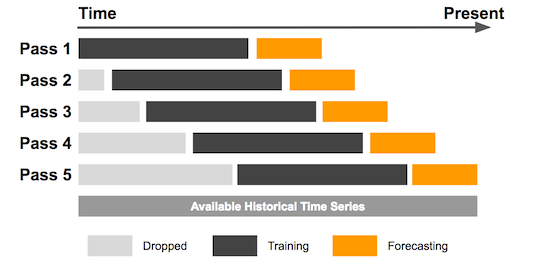

Note that we also include the past 20 values of the Dubai crude oil prices to predict the return of the next five days. With this, we have four explanatory variables on the training set.

In [14]:
# Hyperparms
w = 20 # one month lookback 
h = 5 # predict return of next five days  

# Other params
batch_size = 1
seed = 42
shuffle = False

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# check sizes
for inputs, targets in train_ds:
    print(inputs.shape)
    print(targets.shape)
    break

2022-06-07 10:27:38.238900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 10:27:39.025894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3e:00.0, compute capability: 6.1


(1, 20, 4)
(1, 5)


In [15]:
for inputs, targets in test_ds:
    print(inputs)
    print(targets)
    print('---')

tf.Tensor(
[[[-0.71378356  0.44523164 -0.37815119  0.17278502]
  [-0.33304627  0.37095623 -0.39765949  0.27148887]
  [ 0.94003416  0.5461102  -0.52860896  0.27148887]
  [ 0.44334139  0.65827956 -0.54567873  0.1234331 ]
  [ 0.1191723   0.71552866 -0.56250464 -0.02462267]
  [-0.15428843  0.70356642 -0.50251661  0.17278502]
  [ 0.16626622  0.80272398 -0.59615646 -0.56749381]
  [ 0.0252715   0.81488764 -0.60639831  0.02472926]
  [ 0.03307274  0.76701397 -0.61054383 -0.41943804]
  [ 0.34515712  0.76042679 -0.65590063  0.02472926]
  [ 1.01772477  0.83233095 -0.70979231  0.1234331 ]
  [-0.43188892  0.83584718 -0.7573438  -0.27138228]
  [-0.70415126  0.75810502 -0.64005013 -0.02462267]
  [ 0.53076403  0.80700706 -0.60688602 -0.22203035]
  [-0.56812169  0.77790543 -0.64834116 -0.07397459]
  [ 0.84282973  0.84694361 -0.62151725 -0.61684573]
  [ 0.3240775   0.87420407 -0.60639831 -0.07397459]
  [ 0.07065244  0.88568216 -0.61566476 -0.41943804]
  [ 0.69509948  1.02463138 -0.63517306 -0.12332651]
 

In [16]:
print('Number of train splits: ', len(train_ds))
print('Number of val splits: ', len(val_ds))
print('Number of test splits: ', len(test_ds))

Number of train splits:  1365
Number of val splits:  373
Number of test splits:  175


## Multilayer Perceptron

Now, we implement the fully connected neural network in order to make forecasts on the Dubai crude oil price returns. The neural network is built to have a `Flatten` layer at the start before feeding the data into a dense layer with 32 neurons. The output layer would then generate five values, which represents the forecast of crude oil prices for the next five days.

For all neural networks implemented, we use the `Adam` optimizer and the `huber` loss function to find the optimal weights of the neural network. We also evaluate the performance of the neural network using the mean absolute error on the validation and test set.

In [17]:
# MLP

model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 4)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(h, activation="linear")
])

model_mlp.compile(
    optimizer='adam',
    loss='huber',
    metrics=['mae']
)

In [174]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 32)                2592      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,757
Trainable params: 2,757
Non-trainable params: 0
_________________________________________________________________


In [18]:
history_mlp = model_mlp.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1365/1365 [==============================] - 10s 6ms/step - loss: 0.3542 - mae: 0.6597 - val_loss: 0.7942 - val_mae: 1.1718
Epoch 2/5
1365/1365 [==============================] - 8s 6ms/step - loss: 0.3051 - mae: 0.5846 - val_loss: 0.8317 - val_mae: 1.2274
Epoch 3/5
1365/1365 [==============================] - 9s 6ms/step - loss: 0.2940 - mae: 0.5665 - val_loss: 0.7706 - val_mae: 1.1544
Epoch 4/5
1365/1365 [==============================] - 9s 6ms/step - loss: 0.2860 - mae: 0.5525 - val_loss: 0.7665 - val_mae: 1.1500
Epoch 5/5
1365/1365 [==============================] - 9s 6ms/step - loss: 0.2818 - mae: 0.5459 - val_loss: 0.7854 - val_mae: 1.1708


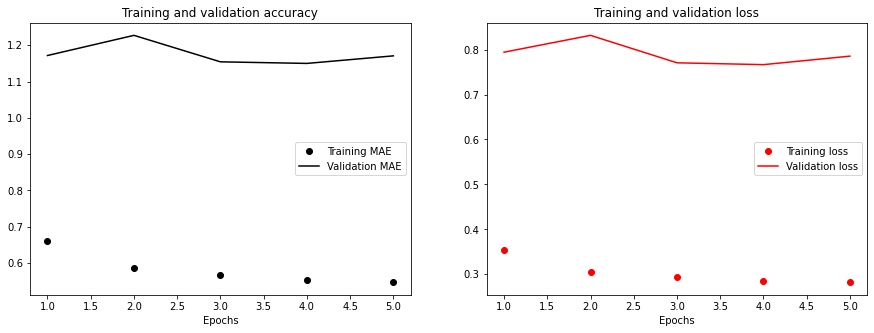

In [20]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    
    # plot accuracy 
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    ax1.plot(epochs, acc, 'ko', label='Training MAE')
    ax1.plot(epochs, val_acc, 'k', label='Validation MAE')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

plot_results(history_mlp)

In [21]:
# unscaled MAE

test_loss, test_mae = model_mlp.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

175/175 [==============================] - 1s 4ms/step - loss: 0.4770 - mae: 0.7985
Test Loss: 0.4770
 Test MAE: 0.7985


## Sample Forecasts

Given that we have a rolling window in splitting the training and testing data, we have 175 splits on the test set. We just visualize the forecast for the first and last train-test split.

RMSE:  0.6305368
 MAE:  0.595302


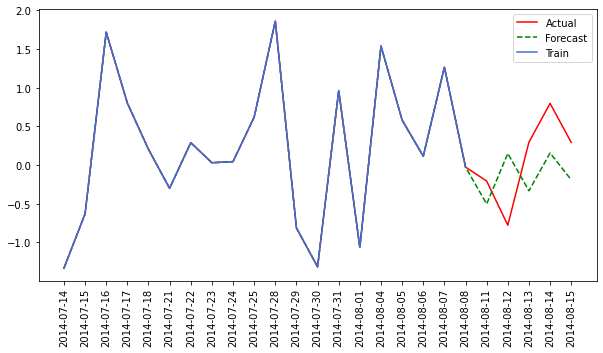

RMSE:  1.4050571
 MAE:  1.0298569


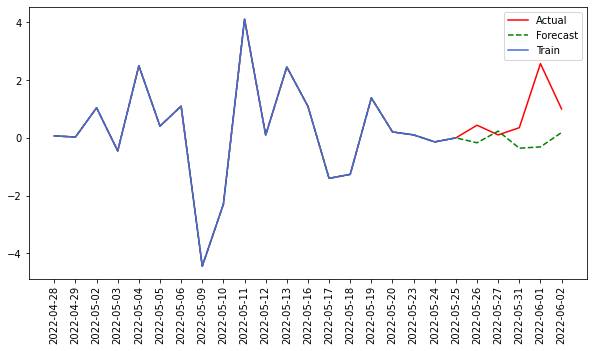

In [22]:
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_mlp.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
        
        if i == 1 or i == 175:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 175:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

## Error Metrics - MAE

After fitting the neural network, we now make predictions on the test set and then reverse the transformations that was done earlier by multiplying the standard deviation of the training set and adding the mean of the training set to the normalized forecast.

This would allow us to calculate error metrics in terms of percent change.

In [23]:
errs_mlp = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_mlp.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_mlp['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_mlp['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change: ')
print("Avg. RMSE: ", np.mean(errs_mlp['RMSE']))
print(" Avg. MAE: ", np.mean(errs_mlp['MAE']))

In percent change: 
Avg. RMSE:  1.8928516
 Avg. MAE:  1.4728135


## Simple Recurrent Neural Network

Recurrent neural networks are a class of neural networks that allow previous outputs to be used as inputs while having hidden states. For sequential data, RNNs are better relative to the MLP regressor as this reduces the number of parameters in our model and it also allows us to have variable lengths of inputs and outputs.

For this implementation, we attempt to stack two RNNs with 150 and 75 units respectively and then put a drop-out layer after the RNNs to avoid overfitting. Lastly, a dense layer is added in order to generate the forecast Dubai oil price return for the next five days.

In this case, we just fit the relevant covariates that tends to explain the oil price returns.

In [24]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(150, return_sequences=True,
              input_shape=(None, 4)))
model_rnn.add(SimpleRNN(75, return_sequences=False,
              input_shape=(None, 4)))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(h))

model_rnn.compile(loss='huber',
                  optimizer='adam', 
                  metrics=['mae'])

In [175]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 150)         23250     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 75)                16950     
                                                                 
 dropout (Dropout)           (None, 75)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 380       
                                                                 
Total params: 40,580
Trainable params: 40,580
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_rnn = model_rnn.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
1365/1365 [==============================] - 63s 45ms/step - loss: 0.4125 - mae: 0.7549 - val_loss: 0.5861 - val_mae: 0.8964
Epoch 2/5
1365/1365 [==============================] - 62s 45ms/step - loss: 0.3435 - mae: 0.6550 - val_loss: 0.5677 - val_mae: 0.8532
Epoch 3/5
1365/1365 [==============================] - 62s 46ms/step - loss: 0.3158 - mae: 0.6080 - val_loss: 0.5712 - val_mae: 0.8594
Epoch 4/5
1365/1365 [==============================] - 62s 46ms/step - loss: 0.2986 - mae: 0.5766 - val_loss: 0.5665 - val_mae: 0.8492
Epoch 5/5
1365/1365 [==============================] - 62s 45ms/step - loss: 0.2946 - mae: 0.5679 - val_loss: 0.5687 - val_mae: 0.8502


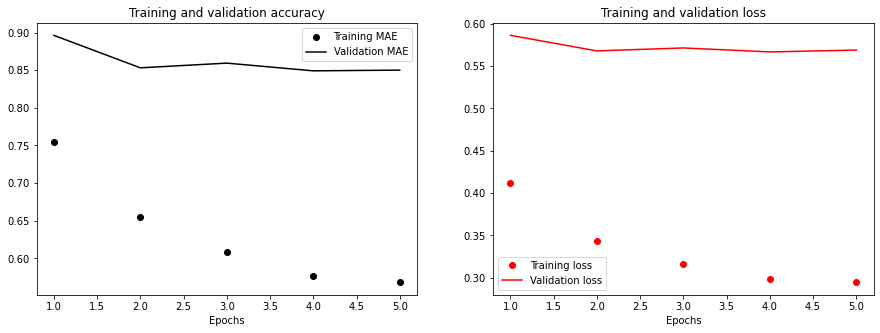

In [26]:
plot_results(history_rnn)

In [27]:
test_loss, test_mae = model_rnn.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}")

175/175 [==============================] - 3s 14ms/step - loss: 0.4378 - mae: 0.7262
Test Loss: 0.4378
 Test MAE: 0.7262


RMSE:  0.5780098
 MAE:  0.48565084


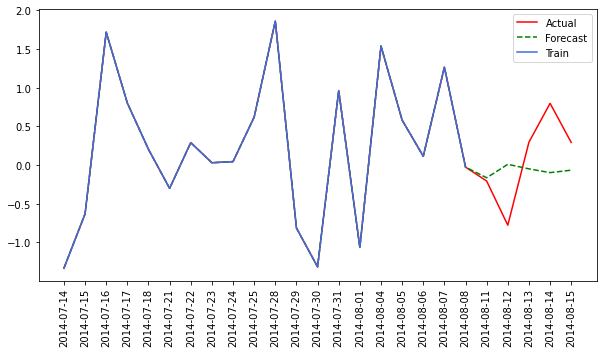

RMSE:  1.0769883
 MAE:  0.78699553


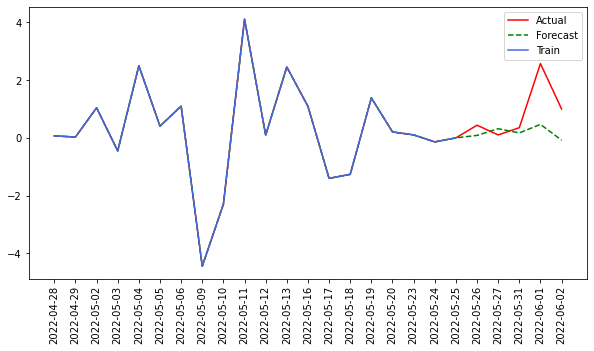

In [28]:
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_rnn.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
        
        if i == 1 or i == 175:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 175:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [29]:
errs_gru = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_rnn.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_gru['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_gru['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change:')
print("Avg. RMSE: ", np.mean(errs_gru['RMSE']))
print(" Avg. MAE: ", np.mean(errs_gru['MAE']))

In percent change:
Avg. RMSE:  1.7719147
 Avg. MAE:  1.3394685


We see an improvement in the accuracy of the forecast when the simple RNN is used for forecasting. From a MAE of 1.47, the RNN was able to yield an average MAE of 1.33. This improvement tends to translate in an improvement of 0.14% when forecasting the up and down swings of the Dubai crude oil prices.

Let us now compare the performance of the model when we use derived features from the Dubai oil price returns instead by using the tsFresh library.

## Extract TSFresh Features

In [54]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame

In [130]:
ts_data = ts_df.reset_index('Date')
ts_data["ticker"] = "Dubai"
y = ts_df['Return'][5:]

df_rolled = roll_time_series(ts_data, column_id="ticker", column_sort="Date",
                             max_timeshift=20, min_timeshift=5)

X_return = extract_features(df_rolled.drop("ticker", axis=1),
                            column_id="id", column_sort="Date", 
                            impute_function=impute,
                            column_value="Return", show_warnings=False)

X_CRB = extract_features(df_rolled.drop("ticker", axis=1),
                            column_id="id", column_sort="Date", 
                            impute_function=impute,
                            column_value="crb_index", show_warnings=False)

X_USD = extract_features(df_rolled.drop("ticker", axis=1),
                            column_id="id", column_sort="Date", 
                            impute_function=impute,
                            column_value="us_dollar_index", show_warnings=False)

X_google = extract_features(df_rolled.drop("ticker", axis=1),
                            column_id="id", column_sort="Date", 
                            impute_function=impute,
                            column_value="google_searches", show_warnings=False)

/home/msds2022/jegonzales/.local/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Feature Extraction: 100%|██████████| 80/80 [01:03<00:00,  1.26it/s]


In [131]:
X_return = X_return.set_index(X_return.index.map(lambda x: x[1]), drop=True)
X_return.index.name = "Date"

X_CRB = X_CRB.set_index(X_CRB.index.map(lambda x: x[1]), drop=True)
X_CRB.index.name = "Date"

X_USD = X_USD.set_index(X_USD.index.map(lambda x: x[1]), drop=True)
X_USD.index.name = "Date"

X_google = X_google.set_index(X_google.index.map(lambda x: x[1]), drop=True)
X_google.index.name = "Date"

In [132]:
X_return_filtered = select_features(X_return, y)
X_CRB_filtered = select_features(X_CRB, y)
X_USD_filtered = select_features(X_USD, y)
X_google_filtered = select_features(X_google, y)

In [ ]:
ts_tsfresh = X_return_filtered
ts_tsfresh['Return'] = y
ts_tsfresh = ts_tsfresh.sort_index(axis=1)

In [106]:
# 70-20-10 split
train_size = int(0.7 * len(ts_tsfresh))
val_size = int(0.2 * len(ts_tsfresh))
test_size = len(ts_tsfresh) - train_size - val_size

print(f'Train size: {train_size}')
print(f'  Val size: {val_size}')
print(f' Test size: {test_size}')

Train size: 1386
  Val size: 396
 Test size: 198


In [107]:
# Normalize per dataframe column
train_mean = ts_tsfresh[:train_size].mean()
train_std = ts_tsfresh[:train_size].std()

ts_tsfresh_norm = (ts_tsfresh - train_mean) / train_std

ts_tsfresh_norm

,Return,"Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""",...,Return__quantile__q_0.6,Return__quantile__q_0.7,Return__quantile__q_0.8,Return__quantile__q_0.9,Return__range_count__max_0__min_-1000000000000.0,Return__range_count__max_1000000000000.0__min_0,Return__skewness,Return__sum_values,Return__symmetry_looking__r_0.1,Return__variance_larger_than_standard_deviation
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-21,0.137879,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.390723,-0.169719,-0.622586,-0.920625,-2.848725,-2.491241,-0.185965,0.076652,0.09342,-1.703564
2014-07-22,0.020303,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.019423,-0.316065,-0.679343,-0.922420,-2.848725,-2.131230,-0.139361,0.078517,0.09342,-1.703564
2014-07-23,0.071281,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,-0.093191,-0.455815,-0.736101,-0.924216,-2.848725,-1.771220,-0.191423,0.089709,0.09342,-1.703564
2014-07-24,-0.091738,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,-0.278841,-0.582373,-0.792858,-0.926011,-2.492345,-1.771220,-0.022008,0.071078,0.09342,-1.703564
2014-07-25,0.137650,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.026957,-0.414644,-0.849616,-0.927807,-2.492345,-1.411210,-0.133476,0.094410,0.09342,-1.703564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,0.247630,0.509519,0.299351,-0.534003,0.929903,0.338013,-0.239578,-0.878613,1.254533,0.858238,...,1.226306,2.348255,0.817421,1.103824,-1.423205,1.468874,-0.171374,0.534240,0.09342,0.586581
2022-05-27,0.065454,0.531763,0.404142,-0.509438,0.968274,0.512381,-0.199663,-0.871670,-0.720411,0.840530,...,1.226306,2.348255,0.817421,1.103824,-1.423205,1.468874,-0.173005,0.537611,0.09342,0.586581
2022-05-31,0.201113,0.373400,0.527293,-0.527731,0.817401,0.637928,-0.229386,-0.815677,-0.283027,0.854426,...,1.226306,2.348255,0.817421,1.103824,-1.423205,1.468874,-0.188234,0.569661,0.09342,0.586581


In [108]:
target = ['Return']
covariates = list(ts_tsfresh_norm.columns.drop('Return'))

ts = ts_tsfresh_norm[target + covariates].to_numpy() # we assume first column is the target
ts_train = ts[:train_size]
ts_val = ts[train_size:train_size+val_size]
ts_test = ts[train_size+val_size:]

In [110]:
# Hyperparms
w = 20 # one month lookback 
h = 5 # predict next 24 hours 

# Other params
batch_size = 1
seed = 42
shuffle = False

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# check sizes
for inputs, targets in train_ds:
    print(inputs.shape)
    print(targets.shape)
    break

(1, 20, 136)
(1, 5)


In [111]:
for inputs, targets in test_ds:
    print(inputs)
    print(targets)
    print('---')

tf.Tensor(
[[[-0.3322294  -0.47313351 -0.41914591 ... -0.68830265  0.09342014
   -1.7035639 ]
  [ 0.93948859 -0.6284159  -1.10011172 ... -0.5264482   0.09342014
    0.58658117]
  [ 0.44332738 -0.56783242 -0.91264099 ... -0.44175684  0.09342014
    0.58658117]
  ...
  [ 0.69481605 -0.41633445 -0.17435337 ...  0.40378061  0.09342014
   -1.7035639 ]
  [-0.00492016 -0.33089357  0.25153276 ...  0.4295318   0.09342014
   -1.7035639 ]
  [-0.10261931 -0.31896407  0.41034725 ...  0.46321632  0.09342014
   -1.7035639 ]]], shape=(1, 20, 136), dtype=float64)
tf.Tensor([[-0.41161196  0.16949081  0.44145311  0.16776749  0.08496481]], shape=(1, 5), dtype=float64)
---
tf.Tensor(
[[[ 0.93948859 -0.6284159  -1.10011172 ... -0.5264482   0.09342014
    0.58658117]
  [ 0.44332738 -0.56783242 -0.91264099 ... -0.44175684  0.09342014
    0.58658117]
  [ 0.11950521 -0.34344478 -0.58576984 ... -0.41902266  0.09342014
    0.58658117]
  ...
  [-0.00492016 -0.33089357  0.25153276 ...  0.4295318   0.09342014
   -1.

In [112]:
print('Number of train splits: ', len(train_ds))
print('Number of val splits: ', len(val_ds))
print('Number of test splits: ', len(test_ds))

Number of train splits:  1362
Number of val splits:  372
Number of test splits:  174


## Multilayer Perceptron - tsFresh

In [113]:
# MLP

model_mlp_tsfresh = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 136)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(h, activation="linear")
])

model_mlp_tsfresh.compile(
    optimizer='adam',
    loss='huber',
    metrics=['mae']
)

In [114]:
history_mlp_tsfresh = model_mlp_tsfresh.fit(train_ds, epochs=5, 
                                            validation_data=val_ds)

Epoch 1/5
1362/1362 [==============================] - 10s 6ms/step - loss: 2.8057 - mae: 3.2375 - val_loss: 6.2535 - val_mae: 6.6533
Epoch 2/5
1362/1362 [==============================] - 9s 6ms/step - loss: 1.4578 - mae: 1.8666 - val_loss: 2.3866 - val_mae: 2.7343
Epoch 3/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.4350 - mae: 0.7617 - val_loss: 0.7229 - val_mae: 1.0391
Epoch 4/5
1362/1362 [==============================] - 8s 6ms/step - loss: 0.3120 - mae: 0.5938 - val_loss: 0.6143 - val_mae: 0.9109
Epoch 5/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.3072 - mae: 0.5846 - val_loss: 0.8782 - val_mae: 1.2165


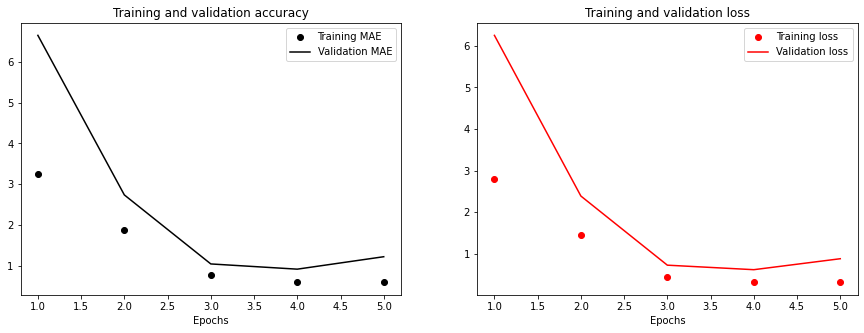

In [115]:
plot_results(history_mlp_tsfresh)

In [117]:
# unscaled MAE

test_loss, test_mae = model_mlp_tsfresh.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

174/174 [==============================] - 1s 4ms/step - loss: 0.4852 - mae: 0.7974
Test Loss: 0.4852
 Test MAE: 0.7974


RMSE:  0.47431406
 MAE:  0.40206093


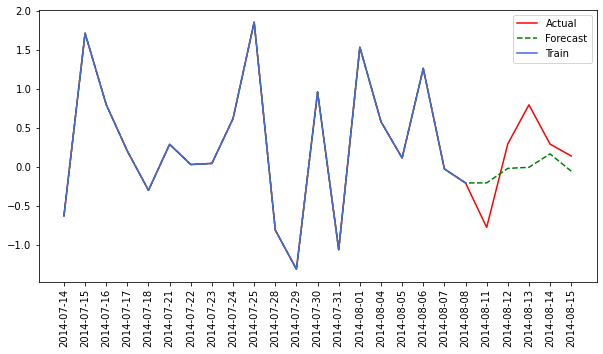

RMSE:  1.2320477
 MAE:  0.8640424


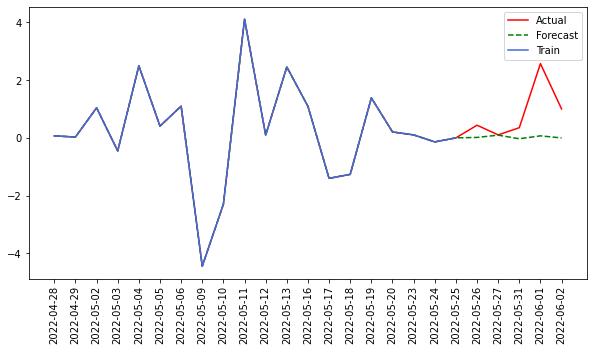

In [119]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_mlp_tsfresh.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
    
        if i == 1 or i == 174:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 174:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [121]:
errs_mlp_tsfresh = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_mlp_tsfresh.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_mlp_tsfresh['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_mlp_tsfresh['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change: ')
print("Avg. RMSE: ", np.mean(errs_mlp_tsfresh['RMSE']))
print(" Avg. MAE: ", np.mean(errs_mlp_tsfresh['MAE']))

In percent change: 
Avg. RMSE:  1.9221151
 Avg. MAE:  1.4722844


## RNN - tsFresh

In [122]:
model_rnn_tsfresh = Sequential()
model_rnn_tsfresh.add(SimpleRNN(150, return_sequences=True,
              input_shape=(None, 136)))
model_rnn_tsfresh.add(SimpleRNN(75, return_sequences=False,
              input_shape=(None, 136)))
model_rnn_tsfresh.add(Dropout(0.2))
model_rnn_tsfresh.add(Dense(h))

model_rnn_tsfresh.compile(loss='huber',
                  optimizer='adam', 
                  metrics=['mae'])

In [124]:
history_rnn_tsfresh = model_rnn_tsfresh.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
1362/1362 [==============================] - 67s 47ms/step - loss: 0.4284 - mae: 0.7739 - val_loss: 0.5961 - val_mae: 0.9034
Epoch 2/5
1362/1362 [==============================] - 63s 47ms/step - loss: 0.3524 - mae: 0.6673 - val_loss: 0.6088 - val_mae: 0.9287
Epoch 3/5
1362/1362 [==============================] - 65s 48ms/step - loss: 0.3194 - mae: 0.6157 - val_loss: 0.5652 - val_mae: 0.8479
Epoch 4/5
1362/1362 [==============================] - 64s 47ms/step - loss: 0.2985 - mae: 0.5779 - val_loss: 0.5639 - val_mae: 0.8383
Epoch 5/5
1362/1362 [==============================] - 64s 47ms/step - loss: 0.2936 - mae: 0.5675 - val_loss: 0.5636 - val_mae: 0.8402


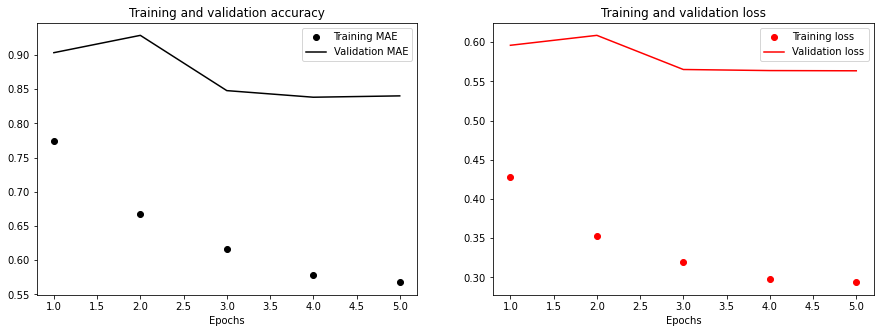

In [125]:
plot_results(history_rnn_tsfresh)

In [126]:
# unscaled MAE

test_loss, test_mae = model_rnn_tsfresh.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

174/174 [==============================] - 2s 13ms/step - loss: 0.4384 - mae: 0.7242
Test Loss: 0.4384
 Test MAE: 0.7242


RMSE:  0.4803027
 MAE:  0.3549605


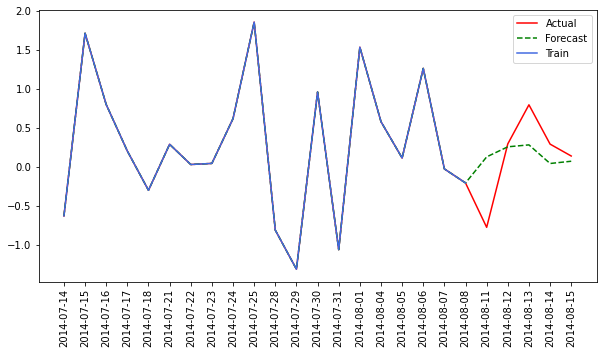

RMSE:  1.1803402
 MAE:  0.78679776


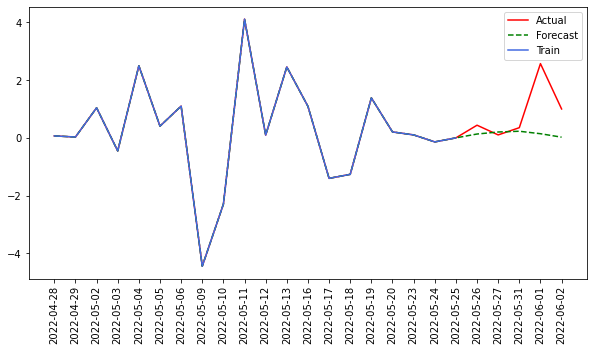

In [127]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_rnn_tsfresh.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
    
        if i == 1 or i == 174:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 174:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [128]:
errs_rnn_tsfresh = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_rnn_tsfresh.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_rnn_tsfresh['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_rnn_tsfresh['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change:')
print("Avg. RMSE: ", np.mean(errs_rnn_tsfresh['RMSE']))
print(" Avg. MAE: ", np.mean(errs_rnn_tsfresh['MAE']))

In percent change:
Avg. RMSE:  1.7714345
 Avg. MAE:  1.3371676


## Add Relevant tsFresh Features from Covariates

In [138]:
ts_new = pd.merge(ts_tsfresh, X_CRB_filtered, left_index=True, right_index=True)
ts_new

,Return,"Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""",...,crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_1,"crb_index__fft_coefficient__attr_""imag""__coeff_1","crb_index__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.4","crb_index__fft_coefficient__attr_""angle""__coeff_2",crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_0,"crb_index__fft_coefficient__attr_""angle""__coeff_3",crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"crb_index__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","crb_index__fft_coefficient__attr_""imag""__coeff_10",crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_8
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-21,0.235916,2.315842,0.080727,-2.398573,0.396451,0.034517,-0.366679,-0.778066,-0.088337,0.779231,...,0.165185,2.641377,-0.500000,55.762217,0.166808,180.000000,0.166046,0.00000,0.102286,0.000000
2014-07-22,0.018829,2.315842,0.080727,-2.398573,0.396451,0.034517,-0.366679,-0.778066,-0.088337,0.779231,...,0.141587,2.431525,0.000000,70.847112,0.142977,-38.552046,0.142324,0.00000,0.102286,0.000000
2014-07-23,0.112952,2.315842,0.080727,-2.398573,0.396451,0.034517,-0.366679,-0.778066,-0.088337,0.779231,...,0.123740,2.872239,-0.500000,71.411031,0.124955,56.491455,0.124384,0.00000,0.102286,0.000000
2014-07-24,-0.188041,2.315842,0.080727,-2.398573,0.396451,0.034517,-0.366679,-0.778066,-0.088337,0.779231,...,0.109936,3.199995,0.000000,93.659125,0.111016,94.093813,0.110509,0.00000,0.102286,0.111554
2014-07-25,0.235494,2.315842,0.080727,-2.398573,0.396451,0.034517,-0.366679,-0.778066,-0.088337,0.779231,...,0.098893,3.462394,0.150000,105.292484,0.099864,56.543062,0.099408,0.00000,0.102286,0.100348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,0.438556,4.172362,0.182818,-4.243512,3.545573,0.243365,-2.417121,-0.998401,0.945544,0.990070,...,0.095406,40.016897,0.247220,-127.171438,0.141214,109.845243,0.096668,-0.41300,-2.764096,0.097835
2022-05-27,0.102192,4.228422,0.252599,-4.187452,3.612846,0.377854,-2.349848,-0.995008,-0.573450,0.981474,...,0.097202,50.422564,0.322686,-62.280217,0.140291,145.020891,0.091938,-0.74365,4.982529,0.097262
2022-05-31,0.352668,3.829317,0.334605,-4.229198,3.348335,0.474688,-2.399943,-0.967645,-0.237044,0.988220,...,0.096049,58.784027,-0.353300,-10.640072,0.141770,-171.206903,0.087451,-2.37740,-5.857871,0.098542


In [139]:
# 70-20-10 split
train_size = int(0.7 * len(ts_new))
val_size = int(0.2 * len(ts_new))
test_size = len(ts_new) - train_size - val_size

print(f'Train size: {train_size}')
print(f'  Val size: {val_size}')
print(f' Test size: {test_size}')

Train size: 1386
  Val size: 396
 Test size: 198


In [140]:
# Normalize per dataframe column
train_mean = ts_new[:train_size].mean()
train_std = ts_new[:train_size].std()

ts_new_norm = (ts_new - train_mean) / train_std

ts_new_norm

,Return,"Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""",...,crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_1,"crb_index__fft_coefficient__attr_""imag""__coeff_1","crb_index__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.4","crb_index__fft_coefficient__attr_""angle""__coeff_2",crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_0,"crb_index__fft_coefficient__attr_""angle""__coeff_3",crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"crb_index__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","crb_index__fft_coefficient__attr_""imag""__coeff_10",crb_index__energy_ratio_by_chunks__num_segments_10__segment_focus_8
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-21,0.137879,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,13.711780,0.258014,-0.850155,0.569047,3.606762,1.838008,15.937883,-0.004341,0.045723,-15.827830
2014-07-22,0.020303,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,9.034802,0.251531,0.086422,0.722026,-0.107393,-0.382423,10.555757,-0.004341,0.045723,-15.827830
2014-07-23,0.071281,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,5.497752,0.265145,-0.850155,0.727745,-2.916290,0.583194,6.485426,-0.004341,0.045723,-15.827830
2014-07-24,-0.091738,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,2.762035,0.275270,0.086422,0.953368,-5.088820,0.965224,3.337244,-0.004341,0.045723,2.869446
2014-07-25,0.137650,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.573443,0.283376,0.367395,1.071345,-6.826859,0.583718,0.818677,-0.004341,0.045723,0.991318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,0.247630,0.509519,0.299351,-0.534003,0.929903,0.338013,-0.239578,-0.878613,1.254533,0.858238,...,-0.117744,1.412573,0.549503,-1.286127,-0.382260,1.125254,0.196941,-0.561289,-0.743285,0.570076
2022-05-27,0.065454,0.531763,0.404142,-0.509438,0.968274,0.512381,-0.199663,-0.871670,-0.720411,0.840530,...,0.238268,1.734013,0.690862,-0.628050,-0.525974,1.482630,-0.876116,-1.007185,1.389073,0.474028
2022-05-31,0.201113,0.373400,0.527293,-0.527731,0.817401,0.637928,-0.229386,-0.815677,-0.283027,0.854426,...,0.009833,1.992305,-0.575363,-0.104355,-0.295525,-1.730162,-1.894350,-3.210369,-1.594886,0.688525


In [141]:
target = ['Return']
covariates = list(ts_new_norm.columns.drop('Return'))

ts = ts_new_norm[target + covariates].to_numpy() # we assume first column is the target
ts_train = ts[:train_size]
ts_val = ts[train_size:train_size+val_size]
ts_test = ts[train_size+val_size:]

In [142]:
# Hyperparms
w = 20 # one month lookback 
h = 5 # predict next 24 hours 

# Other params
batch_size = 1
seed = 42
shuffle = False

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# check sizes
for inputs, targets in train_ds:
    print(inputs.shape)
    print(targets.shape)
    break

(1, 20, 203)
(1, 5)


In [143]:
print('Number of train splits: ', len(train_ds))
print('Number of val splits: ', len(val_ds))
print('Number of test splits: ', len(test_ds))

Number of train splits:  1362
Number of val splits:  372
Number of test splits:  174


## MLP - tsFresh for Target and Covariate

In [144]:
# MLP
model_mlp_new = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 203)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(h, activation="linear")
])

model_mlp_new.compile(
    optimizer='adam',
    loss='huber',
    metrics=['mae']
)

In [145]:
history_mlp_new = model_mlp_new.fit(train_ds, epochs=5, 
                                    validation_data=val_ds)

Epoch 1/5
1362/1362 [==============================] - 9s 6ms/step - loss: 3.5570 - mae: 3.9951 - val_loss: 7.9229 - val_mae: 8.3144
Epoch 2/5
1362/1362 [==============================] - 9s 6ms/step - loss: 2.2710 - mae: 2.7056 - val_loss: 2.3379 - val_mae: 2.7343
Epoch 3/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.5771 - mae: 0.9199 - val_loss: 0.7144 - val_mae: 1.0329
Epoch 4/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.3185 - mae: 0.6065 - val_loss: 0.6556 - val_mae: 0.9613
Epoch 5/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.3071 - mae: 0.5911 - val_loss: 0.6366 - val_mae: 0.9432


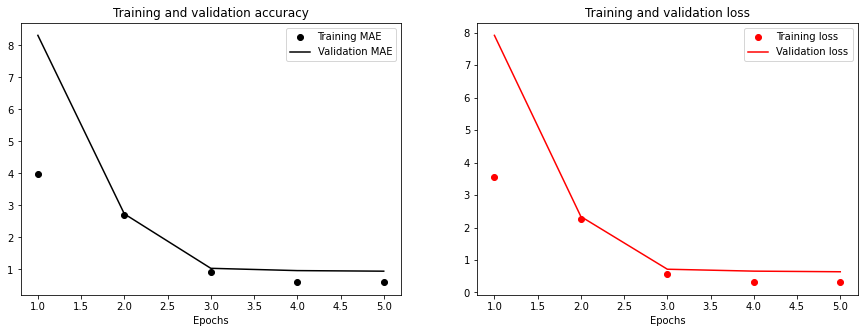

In [146]:
plot_results(history_mlp_new)

In [147]:
# unscaled MAE

test_loss, test_mae = model_mlp_new.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

174/174 [==============================] - 1s 4ms/step - loss: 0.4483 - mae: 0.7492
Test Loss: 0.4483
 Test MAE: 0.7492


RMSE:  0.5128625
 MAE:  0.44879445


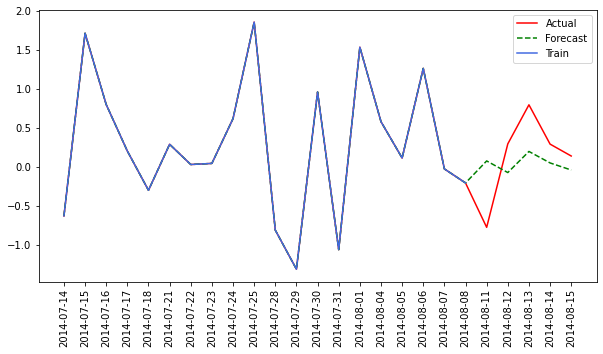

RMSE:  1.3857583
 MAE:  1.0929468


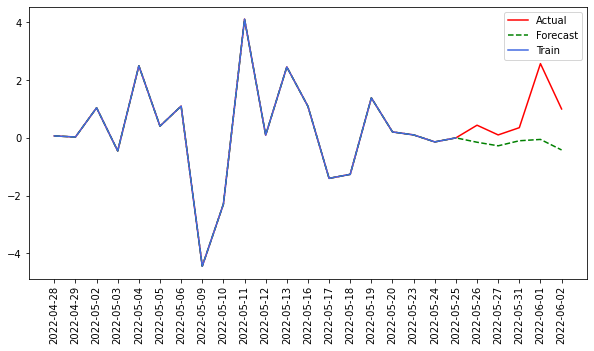

In [149]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_mlp_new.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
    
        if i == 1 or i == 174:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 174:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [150]:
errs_mlp_new = {'RMSE': [], 'MAE': []}

for x_test, y_test in test_ds:
    
    forecast = model_mlp_new.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_mlp_new['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_mlp_new['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change:')
print("Avg. RMSE: ", np.mean(errs_mlp_new['RMSE']))
print(" Avg. MAE: ", np.mean(errs_mlp_new['MAE']))

In percent change:
Avg. RMSE:  1.8142267
 Avg. MAE:  1.3832668


## RNN - tsFresh for Target and Covariate

In [151]:
model_rnn_new = Sequential()
model_rnn_new.add(SimpleRNN(150, return_sequences=True,
              input_shape=(None, 203)))
model_rnn_new.add(SimpleRNN(75, return_sequences=False,
              input_shape=(None, 203)))
model_rnn_new.add(Dropout(0.2))
model_rnn_new.add(Dense(h))

model_rnn_new.compile(loss='huber',
                  optimizer='adam', 
                  metrics=['mae'])

In [152]:
history_rnn_new = model_rnn_new.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
1362/1362 [==============================] - 63s 45ms/step - loss: 0.4482 - mae: 0.7997 - val_loss: 0.5798 - val_mae: 0.8816
Epoch 2/5
1362/1362 [==============================] - 61s 45ms/step - loss: 0.3609 - mae: 0.6841 - val_loss: 0.5675 - val_mae: 0.8547
Epoch 3/5
1362/1362 [==============================] - 61s 45ms/step - loss: 0.3237 - mae: 0.6193 - val_loss: 0.5736 - val_mae: 0.8653
Epoch 4/5
1362/1362 [==============================] - 61s 45ms/step - loss: 0.3034 - mae: 0.5885 - val_loss: 0.5648 - val_mae: 0.8490
Epoch 5/5
1362/1362 [==============================] - 60s 44ms/step - loss: 0.2970 - mae: 0.5730 - val_loss: 0.5637 - val_mae: 0.8410


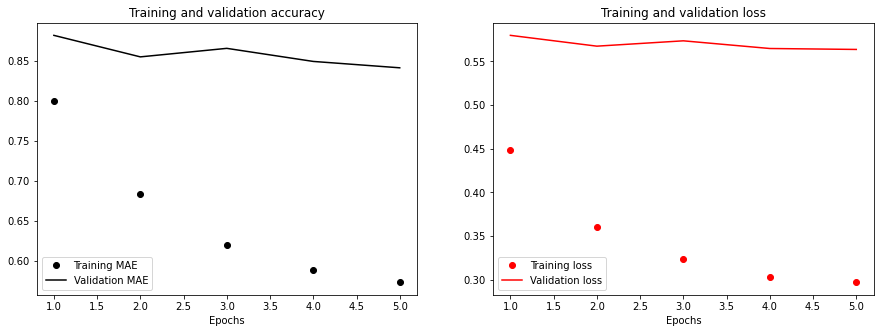

In [153]:
plot_results(history_rnn_new)

In [154]:
# unscaled MAE

test_loss, test_mae = model_rnn_new.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

174/174 [==============================] - 2s 13ms/step - loss: 0.4377 - mae: 0.7223
Test Loss: 0.4377
 Test MAE: 0.7223


RMSE:  0.52598387
 MAE:  0.41414803


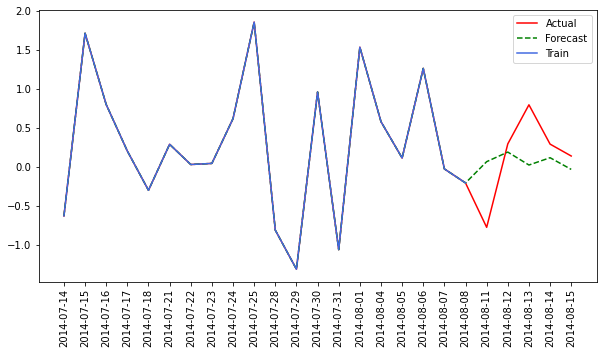

RMSE:  1.1753266
 MAE:  0.831361


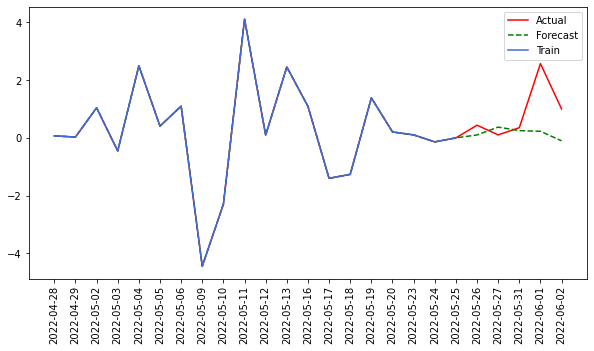

In [155]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_rnn_new.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
    
        if i == 1 or i == 174:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 174:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [156]:
errs_rnn_new = {'RMSE': [], 'MAE': []}

for x_test, y_test in test_ds:
    
    forecast = model_rnn_new.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_rnn_new['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_rnn_new['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change:')
print("Avg. RMSE: ", np.mean(errs_rnn_new['RMSE']))
print(" Avg. MAE: ", np.mean(errs_rnn_new['MAE']))

In percent change:
Avg. RMSE:  1.7692759
 Avg. MAE:  1.3335783


## Summary of Results

| Model | Features | MAE | RMSE | Run Times |
| --- | --- | --- | --- | --- |
| Multilayer Perceptron | Macroeconomic Indicators & Google Trends | 1.4728135 | 1.8928516 | 44 s
| Multilayer Perceptron | TSFresh Extracted Features from Return Series | 1.4722844 | 1.8922115 | 45 s
| Multilayer Perceptron | TSFresh Extracted Features from Return Series & Covariates | 1.3832668 | 1.8142267 | 43 s
| RNN | Macroeconomic Indicators & Google Trends | 1.3394685 | 1.7719147 | 5 m 11 s
| RNN | TSFresh Extracted Features from Return Series | 1.3371676  | 1.7714345 | 5 m 23 s
| RNN | TSFresh Extracted Features from Return Series & Covariates | 1.3335783 | 1.7692759 | 5 m 7 s

## Insights

- TSFresh could help in feature engineering as it performs equally as well relative to knowing possible covariates that tend to explain the movement of the time-series data.
- TSFresh is useful especially if one may not have the domain knowledge in modelling time-series data! Sharyl and I are lucky that we are modelling economic data as this is within our comfort zone, but TSFresh is something that we would use especially if we are tasked to make forecasts on failure-analysis related datasets :D
- Lastly, appending relevant features extracted by TSFresh on the known covariates of the time-series data would tend to improve performance of the time-series!